In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.agents.constant import AllC, AllD
from society.agents.qlearning import DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.simulations.adaptive import AdaptiveSimulation
from society.util import (
    calculate_cooperativeness,
    compute_policies,
    generate_population,
)
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
generate_agents = lambda population: [
    DoubleTabularQLearner(
        lookback=3, epsilon=0.1, learning_rate=0.05, discount_factor=0.99
    )
    for _ in range(population)
]

In [3]:
POPULATION = 128
ROUNDS = 20_000
RUNS = 5
SHOW_VISUALS = False

run_rewards = []
run_cumulative_rewards = []
run_reward_histories = []
run_policies = []
run_weights = {}
run_coop = {}

for run in range(RUNS):
    epoch_rewards = []

    # Generate a new population
    agents, weights_matrix, G = generate_population(generate_agents, POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        r = sim.play_round(train=True)
        epoch_rewards.append(r)

        if i % 2000 == 1999:
            if i not in run_weights:
                run_weights[i] = []
                run_coop[i] = []

            M = sim.produce_weight_matrix()
            run_weights[i].append(M)

            if SHOW_VISUALS:
                sns.kdeplot(M.ravel())
                plt.title(f"Weights - Iteration {i}")
                plt.show()

            C = sim.calculate_cooperativeness_proportions()
            run_coop[i].append(C)

    # Store results
    run_rewards.append(sim.rewards)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [
        (i, sum(history)) for i, history in enumerate(sim.reward_histories)
    ]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    if SHOW_VISUALS:
        for rh in sim.reward_histories:
            plt.plot(np.cumsum(rh))

        plt.show()

        plt.plot(sim.differences)
        plt.show()

        plt.plot(epoch_rewards)
        plt.show()

Run 1:   0%|          | 0/20000 [00:00<?, ?it/s]

BEST AGENT (67): 118783 (0.7859892627995286, CCCDDCCCDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCDCCCCCCDCCCCCCCCCCCCCC)
WORST AGENT (22): 107921 (0.5860817225652323, DCDCDCCCCCDCCDCCDCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCDCCCCCCCC)


Run 2:   0%|          | 0/20000 [00:00<?, ?it/s]

BEST AGENT (99): 119254 (0.7801095129555399, CCCCDCCCDCCCCCCCCCCCCCCCDCCCCCDCCDCCCDCCCCCCCCCCCCCCCCCCCCCCCCCC)
WORST AGENT (41): 108994 (0.6537657211864157, DCDCDCCCCCCCCCDDCCCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCCC)


Run 3:   0%|          | 0/20000 [00:00<?, ?it/s]

BEST AGENT (40): 119042 (0.852596146600015, CCCCCCCCDCCCCCCCCCCCCCCCDCDCCCCCCDCCCCCCCCDCCCCCCCCCCCCCCDCCCCCC)
WORST AGENT (44): 107015 (0.5948689553340716, DCDCCCCDCCDCCCCCCCCCCCDCCCCCCCCCCCCCCCCCDDCCDCCCCCCCCCCCCCCCCCCC)


Run 4:   0%|          | 0/20000 [00:00<?, ?it/s]

BEST AGENT (7): 119254 (0.8157233027146302, CDCCCDCCDCDCCCCDCCCCCCCCCCCCCCCDCCCCCCCCCCCCCCCCCCCCCCCCCCDCCCCC)
WORST AGENT (90): 110603 (0.6208415752562488, DCCDCCCCDDCDCCCCCCCCCCCCCCCCCCCCCCCCCCCDCDCCCCCCCCCCCCCCCCCCCCCC)


Run 5:   0%|          | 0/20000 [00:00<?, ?it/s]

BEST AGENT (30): 119511 (0.7751002956081081, CCCCDDCDDCCCCCDCCCCCCCCCCCCCCCCCCDCCCDCCCCCCCCCCCCCCCCCCCCCCCCCC)
WORST AGENT (65): 108877 (0.6444700597032571, DCDCCCDCCCCCCCCCCCCCCCCCCDCCCCCCCCCCCDCCDCCCCDCCCCCDCCCCCCCCCDCC)


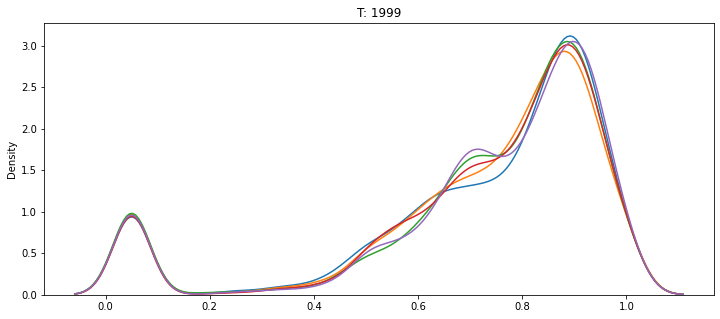

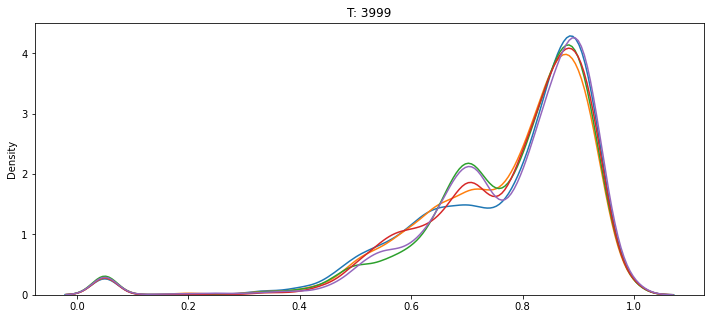

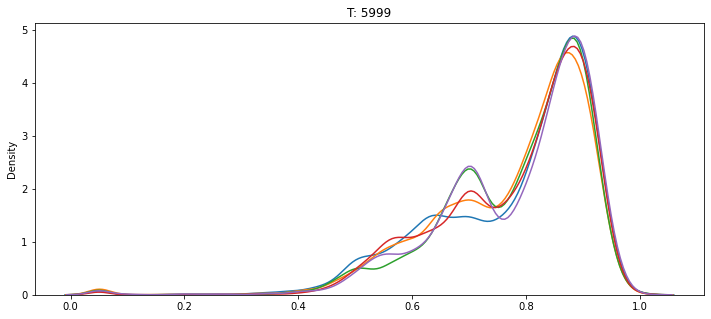

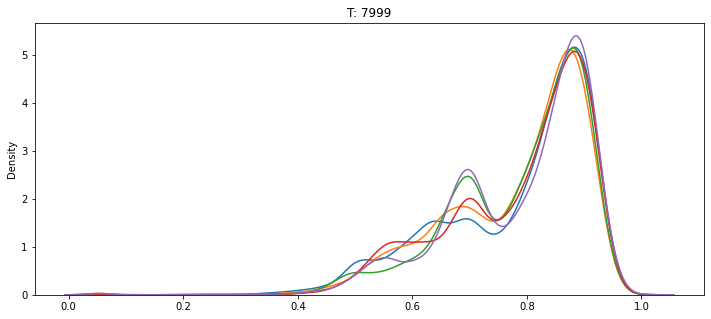

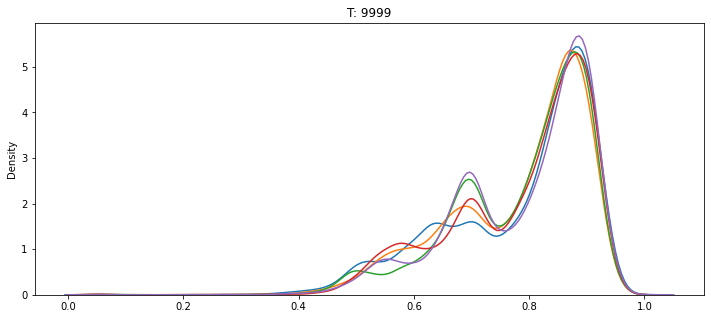

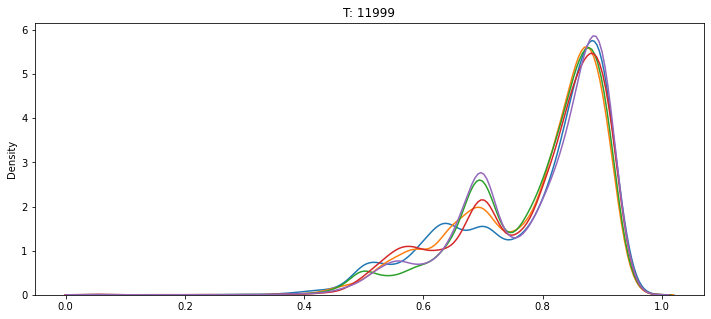

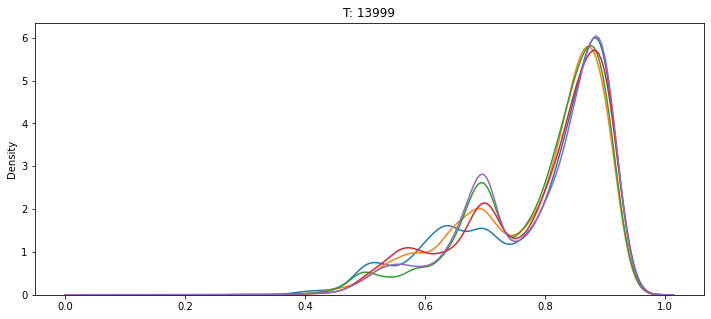

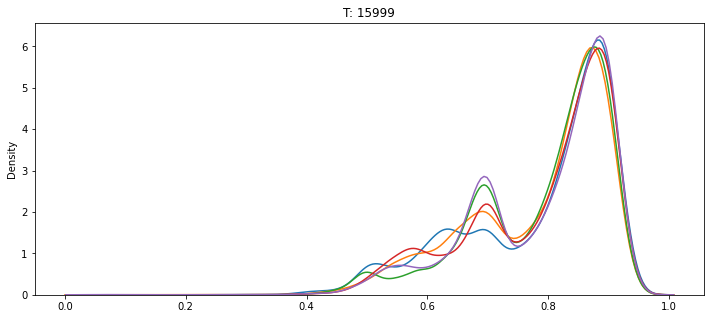

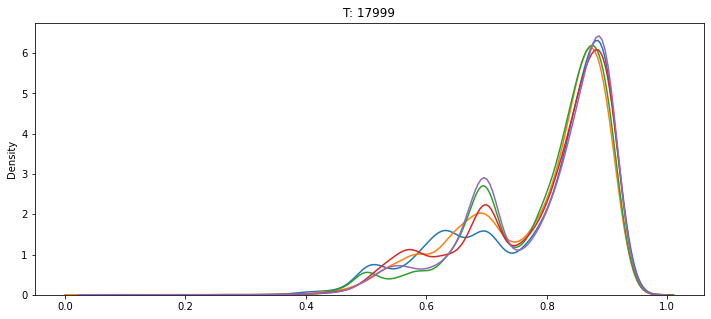

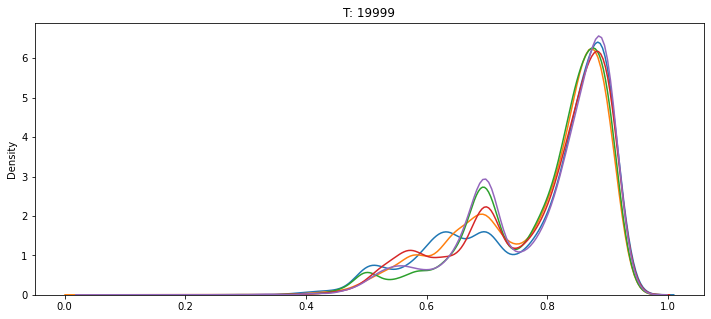

In [4]:
for i in sorted(run_weights.keys()):
    for w in run_weights[i]:
        sns.kdeplot(w.ravel())

    plt.title(f"T: {i}")
    plt.show()

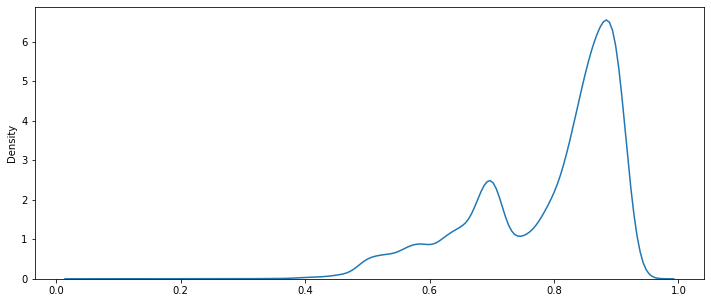

In [5]:
from itertools import chain

sns.kdeplot(list(chain.from_iterable([w.ravel() for w in run_weights[ROUNDS - 1]])))
plt.show()

PEAKS: [585 697 884]
PEAK PROPERTIES: {'peak_heights': array([0.88050588, 2.4865298 , 6.55239507])}
MODES: [0.585 0.697 0.884]
MODAL DENSITIES: [0.88050588 2.4865298  6.55239507]


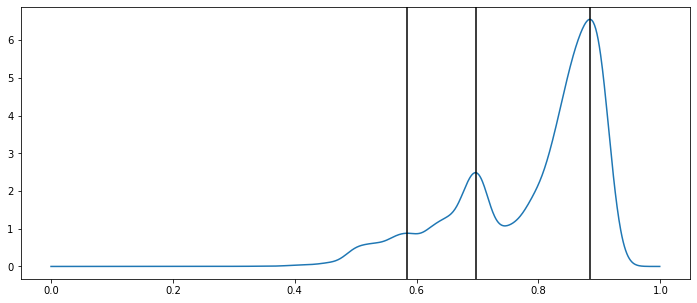

In [6]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

r = np.arange(0, 1, 0.001)

kernel = gaussian_kde(
    [
        v
        for v in chain.from_iterable([w.ravel() for w in run_weights[ROUNDS - 1]])
        if v >= 0
    ]
)
kde = kernel(r)
peaks, peak_properties = find_peaks(kde, height=0.1)

print("PEAKS:", peaks)
print("PEAK PROPERTIES:", peak_properties)
print("MODES:", r[peaks])
print("MODAL DENSITIES:", kde[peaks])

plt.plot(r, kde)

for v in r[peaks]:
    plt.axvline(x=v, color="black")

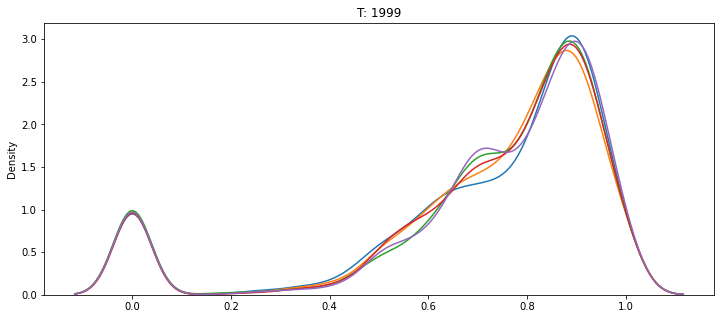

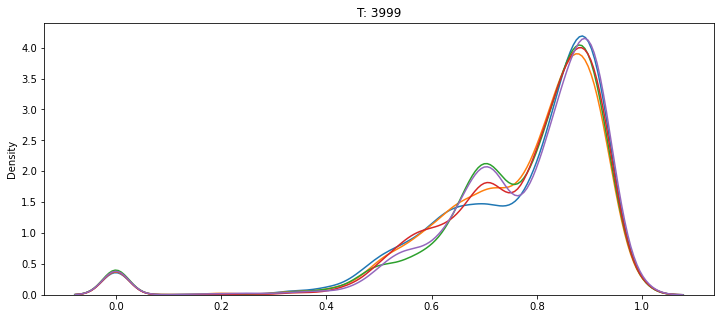

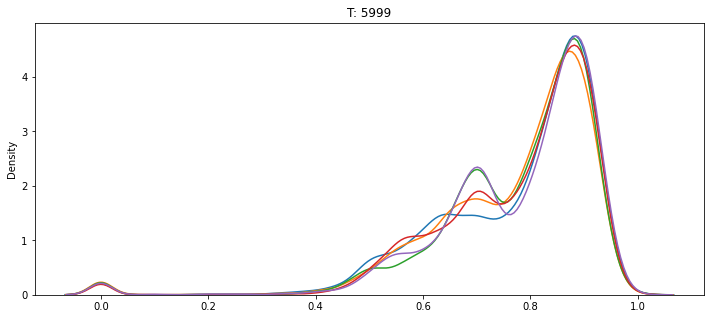

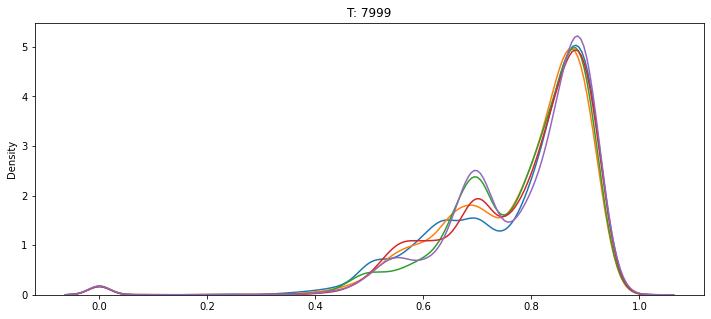

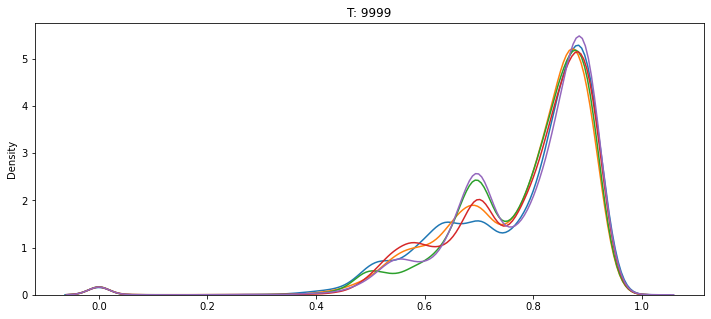

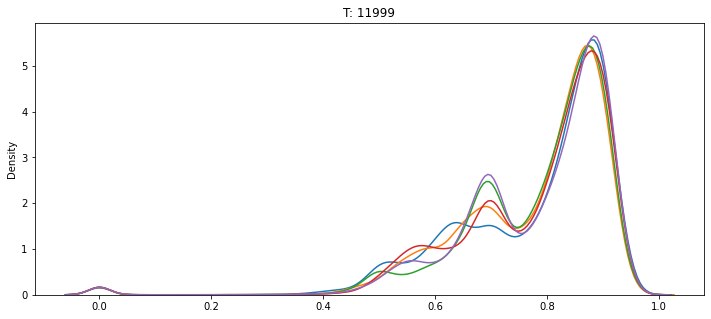

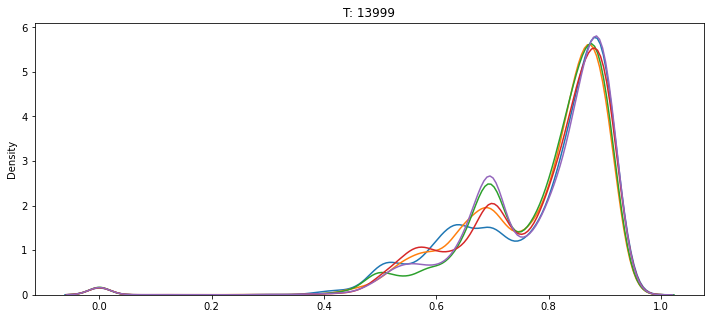

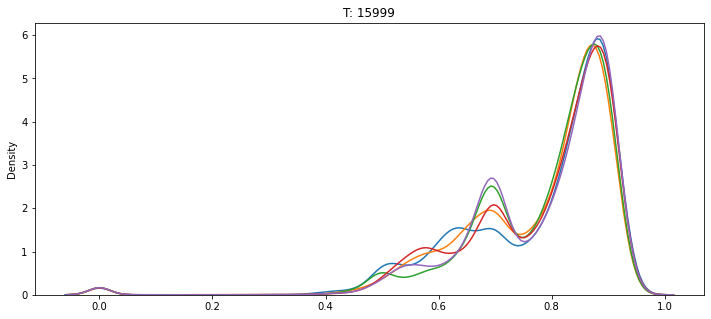

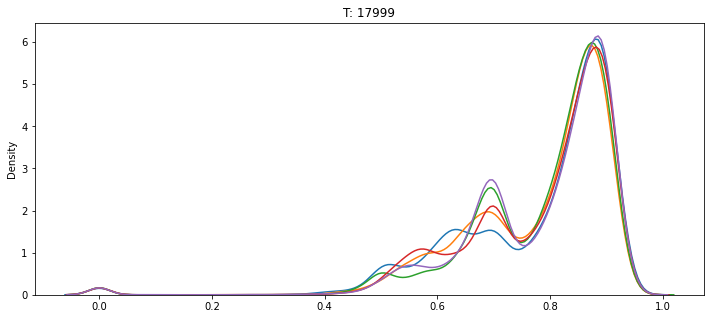

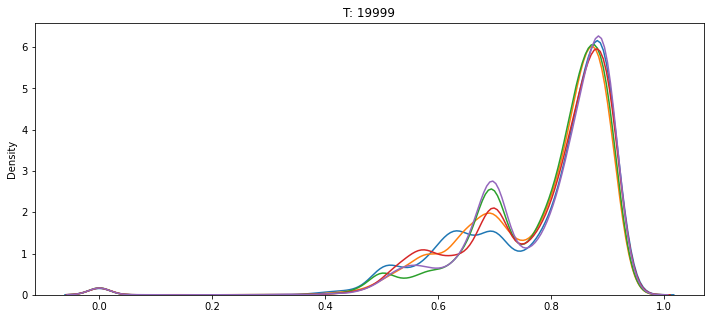

In [7]:
for i in sorted(run_coop.keys()):
    for w in run_coop[i]:
        sns.kdeplot(w.ravel())

    plt.title(f"T: {i}")
    plt.show()

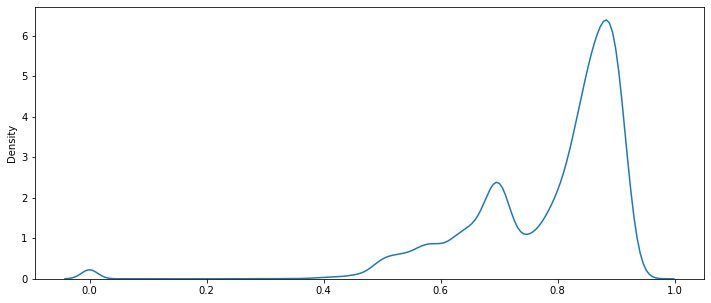

In [8]:
sns.kdeplot(list(chain.from_iterable([w.ravel() for w in run_coop[ROUNDS - 1]])))
plt.show()

0.99	0	None
0.975	0	None
0.95	2	0.0
0.925	115	0.03616946778711485
0.9	1030	0.34107469568397464
0.875	2499	0.6911230138646551
0.85	3673	0.7796454826742355
0.825	4507	0.8370993878076083
0.8	5001	0.8750126747000269
0.7	6057	0.922807462835557
0.6	7293	0.9451524304795488
0.5	7926	0.9809387840352879
0.4	8112	0.9980745937609617
0.3	8126	0.9997558898887638
0.2	8128	1.0
0.1	8128	1.0


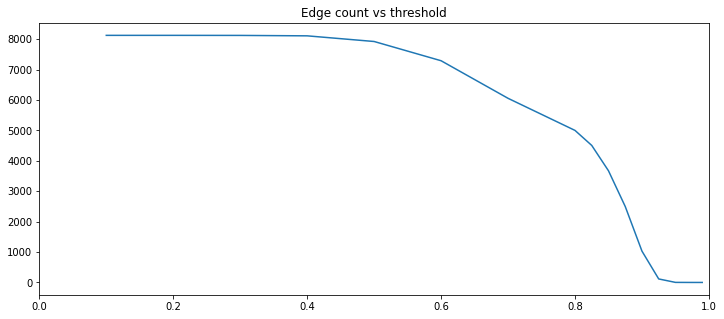

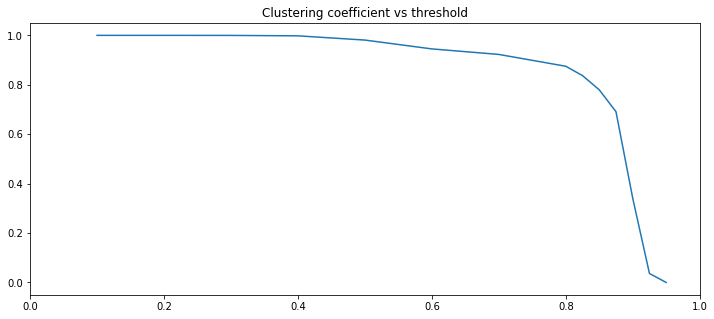

In [9]:
from datetime import datetime

dt = datetime.isoformat(datetime.now()).replace(":", "-").replace("T", " ")

weights = run_weights[ROUNDS - 1][0]

thresholds = [
    0.99,
    0.975,
    0.95,
    0.925,
    0.9,
    0.875,
    0.85,
    0.825,
    0.8,
    0.7,
    0.6,
    0.5,
    0.4,
    0.3,
    0.2,
    0.1,
]
edge_counts = []
clustering_coefficients = []

Ks = []

for threshold in thresholds:
    edges = [
        (i, j, (weights[i, j] + weights[j, i]))
        for i in range(POPULATION)
        for j in range(i + 1, POPULATION)
        if i != j and weights[i, j] > threshold and weights[j, i] > threshold
    ]

    K = nx.Graph()
    K.add_weighted_edges_from(edges)
    # nx.drawing.nx_pydot.write_dot(K, f"{dt} - {threshold} - reduced.dot")

    try:
        clustering_coefficient = nx.algorithms.cluster.average_clustering(K)
    except:
        clustering_coefficient = None

    edge_count = len(edges)

    print(threshold, edge_count, clustering_coefficient, sep="\t")

    edge_counts.append(edge_count)
    clustering_coefficients.append(clustering_coefficient)

    Ks.append(K)

plt.xlim(left=0, right=1)
plt.title("Edge count vs threshold")
plt.plot(thresholds, edge_counts)
plt.show()

plt.xlim(left=0, right=1)
plt.title("Clustering coefficient vs threshold")
plt.plot(thresholds, clustering_coefficients)
plt.show()

IndexError: list index out of range

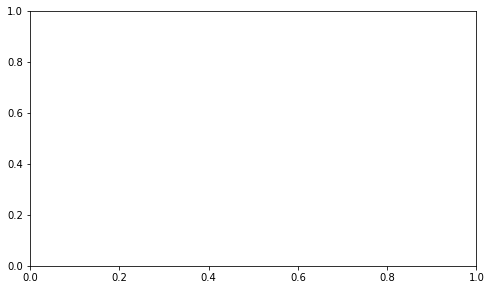

In [10]:
for threshold, K in zip(thresholds, Ks):
    plot_degree_distribution(K, threshold)